<a href="https://colab.research.google.com/github/Lynda-Starkus/tsaug-tsclass/blob/master/Time_series_augmentation_25_03_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 1 : baseline time series augmentation techniques**


### 1°/ **Augmentation with time series generation from healthy disks**
*   Exploring simple (baseline) time series manipulation methods :    


1.   Adding a constant to a time series (scaling)
2.   Multiplying a time series by a constant (magnifying)
3.   Adding a given number drops or peaks
4.   Magnitude wrapping (adding a smoothly varying noise until we reach a failure)






*   Exploring more complex data augmentation techniques :  


1.   Using data augmentation using tsaug library





### 2°/ **Augmentation with time series oversampling from failed disks**



### **Augmentation with time series generation from healthy disks** 

### **Reading the dataset and cleaning**



In [1]:
import pandas as pd
import datetime as dt

In [2]:
#Mounting data from drive
from google.colab import drive
drive.mount('/content/drive')

dataset = pd.read_csv("./drive/Shareddrives/[PFE][ESI-ALGER][LINDA BELKESSA]/Codes/DiskEvolution.csv")

Mounted at /content/drive


In [3]:
dataset.head()

,Unnamed: 0,typeDisk,_time,_value,serverId,diskId
0,0,boot,2021-01-04 12:00:00+00:00,0.822923,0,4
1,1,boot,2021-01-04 14:00:00+00:00,0.822923,0,4
2,2,boot,2021-01-04 16:00:00+00:00,0.822923,0,4
3,3,boot,2021-01-04 18:00:00+00:00,0.822923,0,4
4,4,boot,2021-01-04 20:00:00+00:00,0.822923,0,4


In [4]:
dataset = dataset.drop(columns = dataset.columns[0])

In [5]:
dataset.head()

,typeDisk,_time,_value,serverId,diskId
0,boot,2021-01-04 12:00:00+00:00,0.822923,0,4
1,boot,2021-01-04 14:00:00+00:00,0.822923,0,4
2,boot,2021-01-04 16:00:00+00:00,0.822923,0,4
3,boot,2021-01-04 18:00:00+00:00,0.822923,0,4
4,boot,2021-01-04 20:00:00+00:00,0.822923,0,4


In [6]:
#Treating first type of series : disk evolution
print('Count of unique values in series = \n', dataset['diskId'].value_counts())
print('-----------------------------------')
print('Range of values for "series" [min = ', dataset['diskId'].min(), ' - max = ', dataset['diskId'].max(), ']')
dataset[['_time','_value']].describe()

Count of unique values in series = 
 4       4381
339     4381
354     4381
403     4381
407     4381
        ... 
2456    4381
2464    4381
2472    4381
2477    4381
2612    4380
Name: diskId, Length: 2904, dtype: int64
-----------------------------------
Range of values for "series" [min =  0  - max =  2903 ]


,_value
count,1.272242e+07
mean,7.117169e-01
std,2.017150e-01
min,0.000000e+00
25%,5.761524e-01
50%,7.481046e-01
75%,8.693544e-01
max,1.000000e+00


In [7]:
dataset["diskId"] = dataset["typeDisk"].astype(str) + "-" + dataset["serverId"].astype(str) + "-" + dataset["diskId"].astype(str)

In [8]:
index = dataset['_time'].astype(str)
index = [v.split('+')[0].split('.')[0] for v in index]

In [9]:
index_timer = [dt.datetime.strptime(v, '%Y-%m-%d %H:%M:%S') for v in index]

KeyboardInterrupt: ignored

In [ ]:
dataset.index = index_timer

In [ ]:
dataset = dataset.drop(columns=["typeDisk", "serverId", "_time"])
dataset.head()

In [ ]:
print('Count of null values = ',len(dataset[dataset['_value'].isnull() == True]))

In [ ]:
series_dict = {}

min_timestamp = min(index_timer)
max_timestamp = max(index_timer)
timestamps = pd.date_range(start= min_timestamp, end=max_timestamp, freq='2H')
hourly_data = pd.DataFrame(index=timestamps)

i = 1
for i, id in enumerate(dataset['diskId'].unique()):
    print(i)
    series_dict[id] = dataset.loc[dataset["diskId"] == id] # for dic
    hourly_data[id] =  dataset.loc[dataset["diskId"] == id]['_value']

    i+=1

### **Baseline techniques** 

In [1]:
## Augmentation class

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
import random
import os

class Augmentator:
    def __init__(self):
        pass
    
    def add_peak(self, ts, len_peak=4, peak_factor=2.):
        lenn = len(ts)
        ind_start = random.randint(0, lenn-len_peak-1)
        ind_end = ind_start + len_peak 
        ts_augm = ts.astype(float).copy()
        ts_augm[ind_start:ind_end] *= peak_factor
        
        return ts_augm
    
    def add_flipping(self, ts, b=None):
        if b is None:
            b = np.mean(ts)

        return np.where(2 * b - ts > 0, 2 * b - ts,  0)
    
    def add_smart_peak(self, ts, len_drop = 4, len_peak=4, peak_factor=2.):
        
        lenn = len(ts)
        ind_start = random.randint(0, lenn-len_peak-len_drop-1)
        ind_end = ind_start + len_peak
        ind_start_drop = ind_start + len_peak + 1
        ind_end_drop = ind_start + len_peak + 1 + len_drop
        
        ts_augm = ts.astype(float).copy()
        ts_augm[ind_start:ind_end] *= peak_factor
        ts_augm[ind_start_drop:ind_end_drop] = 0
        
        return ts_augm
    
    def add_exchange(self, ts, len_segm=4):
        lenn = len(ts)
        ind_start_1 = random.randint(0, lenn-len_segm-1)
        ind_end_1 = ind_start_1 + len_segm
        
        if ind_start_1 > lenn - 1 - ind_end_1:
            ind_start_2 = random.randint(0, ind_start_1-len_segm)
            ind_end_2 = ind_start_2 + len_segm
        else:
            ind_start_2 = random.randint(0, lenn - 1 - ind_end_1 - len_segm) + ind_end_1
            ind_end_2 = ind_start_2 + len_segm
        
        ts_augm = ts.astype(float).copy()
        tmp = ts_augm[ind_start_1:ind_end_1].copy()
        ts_augm[ind_start_1:ind_end_1] = ts_augm[ind_start_2:ind_end_2]
        ts_augm[ind_start_2:ind_end_2] = tmp
        
        return ts_augm
        
    
    def add_drops(self, ts, len_drop=12, num_drop=1):
        lenn = len(ts)
        ind_start = random.randint(0, lenn-len_drop-1)
        ind_end = ind_start + len_drop 
        ts_augm = ts.copy()
        ts_augm[ind_start:ind_end] = 0
        
        return ts_augm
    
    def add_norm_noise(self, ts, scale_factor=3):
        len_ts = len(ts)
        diffs = np.diff(ts, 1)
        std = np.std(diffs) / scale_factor
        
        noise = np.random.normal(loc=0.0, scale=std, size=len_ts-1)
        ts_augm = ts.copy()
        ts_augm = ts_augm + noise
        
        ts_augm = np.where(ts_augm<0,0,ts_augm)
        
        return ts_augm
        
        
    def make_ds(self, list_dfs):
        list_dfs_diff = []
        
        for df in list_dfs:
            list_dfs_diff.append(df.diff(1).dropna())
            
        tr_set = pd.concat(list_dfs_diff,axis=0)
        tr_set = tr_set.values.reshape(-1, len(tr_set.columns))
        
        return tr_set

    
    def add_const(self, ts):
        new_ts_vals = []
        const = ts.min()

        new_ts_vals = ts - const
        cut_off = np.argwhere(new_ts_vals == 0)[0][0]

        for i in range(cut_off, len(new_ts_vals), 1):
          new_ts_vals[i] = 0

        return new_ts_vals

  
    def mult_const(self, ts):
      new_ts_vals = []
      const = ts.min() / 0.00001

      new_ts_vals = ts / const
      cut_off = np.argwhere(new_ts_vals == 0.00001)[0][0]

      for i in range(cut_off, len(new_ts_vals), 1):
        new_ts_vals[i] = 0

      return new_ts_vals

In [2]:
# Defining plot settings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output
import random
import os
from scipy import stats
import seaborn as sns 

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

In [3]:
ts = pd.read_csv('test5.csv', index_col='_time')

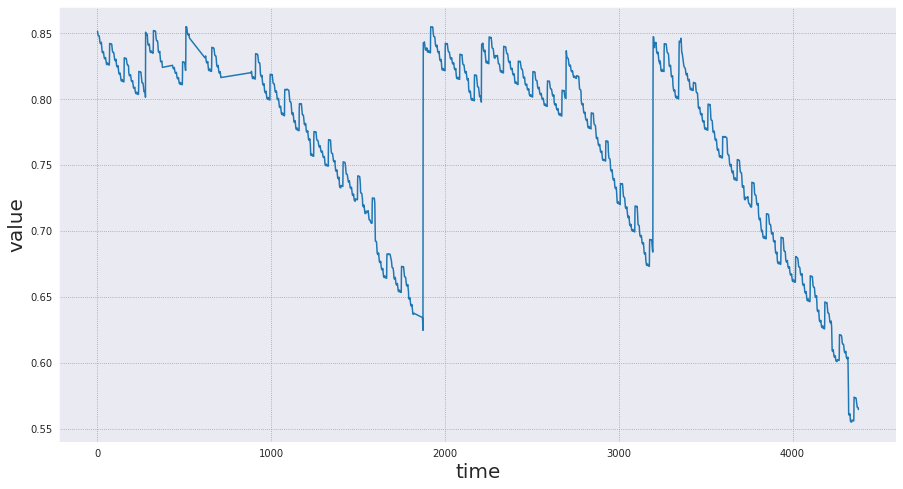

In [4]:
# Original time series
ts_test = ts.values

plt.figure(figsize=(15 , 8))

plt.plot(
    ts_test
)

plt.xlabel('time', fontsize=20)
plt.ylabel('value', fontsize=20)
plt.show()

In [5]:
augm = Augmentator()

#### **Adding X number of drops of given length**

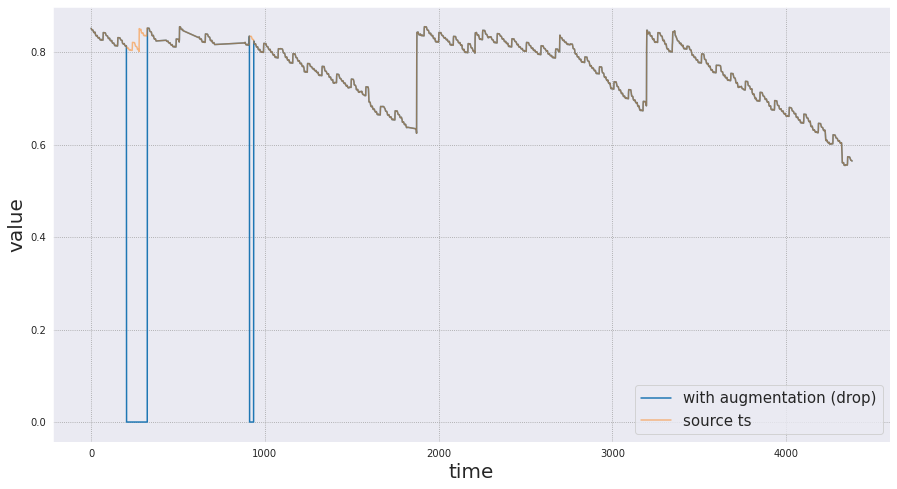

In [6]:
plt.figure(figsize=(15, 8))

drop_train = augm.add_drops(ts.values, len_drop=12*2, num_drop=3)

plt.plot(
    augm.add_drops(drop_train, len_drop=12*10, num_drop=3),
    label='with augmentation (drop)'
)

plt.plot(
    ts.values,
    label='source ts',
    alpha=0.5
)

plt.xlabel('time', fontsize=20)
plt.ylabel('value', fontsize=20)
plt.legend(fontsize=15)
plt.show()

#### **Adding a constant value**

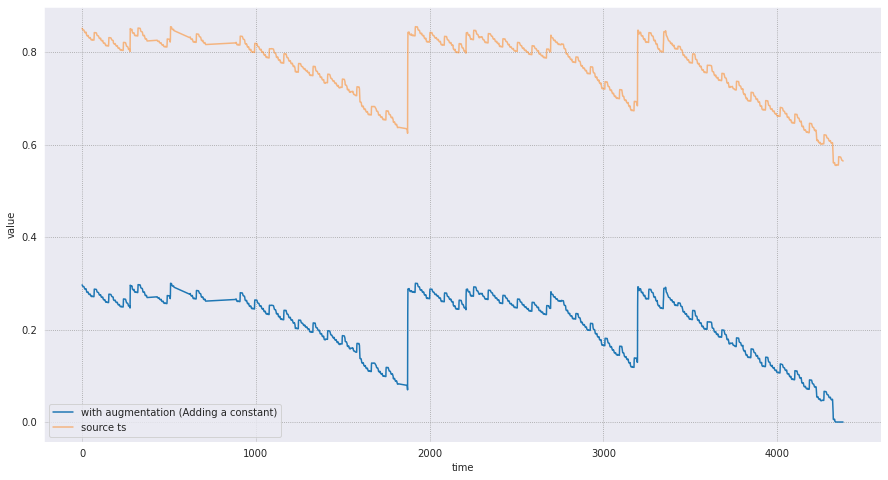

In [7]:
plt.figure(figsize=(15, 8))


orig_plus_const = augm.add_const(ts.values)

plt.plot(
    augm.add_const(ts.values),
    label='with augmentation (Adding a constant)'
)

plt.plot(
    ts.values,
    label='source ts',
    alpha=0.5
)

plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

#### **Multiplying by constant value**

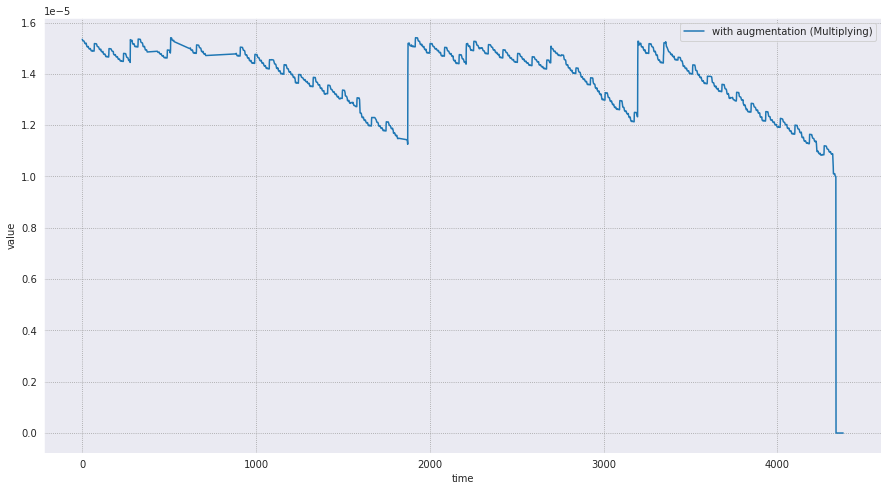

In [8]:
plt.figure(figsize=(15, 8))


orig_mult_const = augm.mult_const(ts.values)

plt.plot(
    augm.mult_const(ts.values),
    label='with augmentation (Multiplying)'
)


plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

#### **Adding a smoothly distributed noise until failure is reaches**

In [9]:
!pip install tsaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import os
import io
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib
#%matplotlib inline
from matplotlib import pyplot as plt
#plt.rcParams['figure.figsize'] = 12, 10

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from PIL import Image
from IPython.display import FileLink

import datetime as dt
from datetime import date, timedelta, datetime

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.tree import DecisionTreeRegressor

from scipy import stats
import statsmodels.api as sm
from itertools import product

# import xgboost as xgb
# from xgboost import plot_tree
from matplotlib.pylab import rcParams

# from fbprophet import Prophet
# from fbprophet.make_holidays import make_holidays_df
# from fbprophet.diagnostics import cross_validation, performance_metrics
# from fbprophet.plot import plot_cross_validation_metric
# import holidays

import tsaug
from tsaug import AddNoise, Convolve, Crop, Drift, Pool, Quantize, Resize, Reverse, TimeWarp
from tsaug.visualization import plot

import warnings
warnings.simplefilter('ignore')

In [11]:
def draw_plot(X_aug, Y_aug):
    plt.plot(X_aug, Y_aug, linewidth=5);
    plt.plot(X, Y, color='r', linewidth=1);

In [12]:
def draw_plot_px(title_plot, X_aug, Y_aug, flag=True):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_aug, y=Y_aug,
                        mode='lines',
                        name='Processed data'))
    if flag:
        fig.add_trace(go.Scatter(x=X, y=Y,
                            mode='lines',
                            name='Origin data'))
    fig.update_layout(title=title_plot)
    fig.show()

In [13]:
def draw_plot_px2(title_plot, X_aug, Y_aug, label1, X_aug2, Y_aug2, label2):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_aug, y=Y_aug,
                        mode='lines',
                        name=label1))
    fig.add_trace(go.Scatter(x=X_aug2, y=Y_aug2,
                        mode='lines',
                        name=label2))
    fig.add_trace(go.Scatter(x=X, y=Y,
                        mode='lines',
                        name='Origin data'))
    fig.update_layout(title=title_plot)
    fig.show()

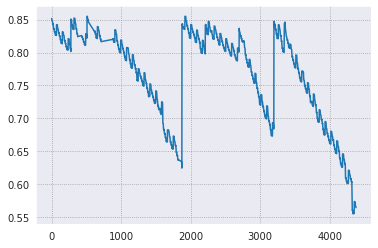

In [14]:
X = np.arange(len(ts))
Y = ts['_value']
plt.plot(X, Y);

In [15]:
Y = np.array(Y.values.tolist())

In [16]:
X = np.array(X)
print(X.shape)
print(Y.shape)

(4380,)
(4380,)


In [17]:
Y_aug, X_aug = tsaug.AddNoise(scale=0.1).augment(Y, X)
Y_aug2, X_aug2 = tsaug.AddNoise(scale=0.05).augment(Y, X)
draw_plot_px2('Adding Noise', X_aug, Y_aug, 'scale=0.1', X_aug2, Y_aug2,'scale=0.05')

In [18]:
Y_aug, X_aug = tsaug.Convolve(window="flat", size=10).augment(Y, X)
Y_aug2, X_aug2 = tsaug.Convolve(window="flat", size=250).augment(Y, X)
draw_plot_px2('Adding Convolution', X_aug, Y_aug, 'flat with size=10', X_aug2, Y_aug2, 'flat with size=30')

In [19]:
Y_aug, X_aug = tsaug.Crop(size=100).augment(Y_aug, X_aug)
Y_aug, X_aug = tsaug.Convolve(window="flat", size=1000).augment(Y_aug, X_aug)

Y_aug2, X_aug2 = tsaug.Crop(size=10).augment(Y, X)
Y_aug2, X_aug2 = tsaug.Convolve(window="flat", size=300).augment(Y_aug2, X_aug2)
draw_plot_px2('Adding Convolution', X_aug, Y_aug, 'Crop, size=100 & Flat, size=10', 
              X_aug2, Y_aug2, 'Crop, size=10 & Flat, size=30')

In [20]:
Y_aug, X_aug = tsaug.Drift(max_drift=0.3, n_drift_points=5).augment(Y, X)
Y_aug2, X_aug2 = tsaug.Drift(max_drift=0.5, n_drift_points=5).augment(Y, X)
draw_plot_px2('Adding Drift', X_aug, Y_aug, 'max_drift=0.3, n_drift_points=5', 
              X_aug2, Y_aug2, 'max_drift=0.5, n_drift_points=5')

In [21]:
Y_aug, X_aug = tsaug.Drift(max_drift=0.3, n_drift_points=5).augment(Y, X)
Y_aug2, X_aug2 = tsaug.Drift(max_drift=0.3, n_drift_points=3).augment(Y, X)
draw_plot_px2('Adding Drift', X_aug, Y_aug, 'max_drift=0.3, n_drift_points=5', 
              X_aug2, Y_aug2, 'max_drift=0.3, n_drift_points=3')

### 2°/ **Augmentation with time series oversampling from failed disks**

In [22]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import pandas as pd
import datetime as dt

In [24]:
#Mounting data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
hourly_data = pd.read_csv("./drive/Shareddrives/[PFE][ESI-ALGER][LINDA BELKESSA]/Codes/full_hourly_cleaned.csv")
hourly_data = hourly_data.set_index(hourly_data.columns[0])

index_timer = [dt.datetime.strptime(v, '%Y-%m-%d %H:%M:%S') for v in hourly_data.index]
hourly_data.index = index_timer

In [26]:
import numpy as np

df_hourly = hourly_data
failed_disks = []

for col in df_hourly.columns:
  for x in df_hourly[col]:
    if x < 0.005:
      failed_disks.append(col)
      break;

In [27]:
!pip install augmentts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 44.8 MB/s eta 0:00:00


In [28]:
from augmentts.augmenters.vae import LSTMVAE, VAEAugmenter

# create a variational autoencoder
vae = LSTMVAE(series_len=4380)
# create an augmenter
augmenter = VAEAugmenter(vae)

In [29]:
data = []
nb_set = 0
for id in failed_disks:
  serie = []
  serie.append(hourly_data[id].values.tolist())
  data.append(serie)
  nb_set+=1

  if nb_set == 3:
    break;

data = np.array(data)
print(data.shape)
augmenter.fit(data, epochs=100, batch_size=32)

(3, 1, 4380)
Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 1.3863 - reconstruction_loss: 1.3863 - kl_loss: 4.2887e-08
Epoch 2/100
1/1 [==============================] - 0s 308ms/step - loss: 1.3825 - reconstruction_loss: 1.3825 - kl_loss: 4.4995e-08
Epoch 3/100
1/1 [==============================] - 0s 322ms/step - loss: 1.3786 - reconstruction_loss: 1.3786 - kl_loss: 4.0929e-08
Epoch 4/100
1/1 [==============================] - 0s 337ms/step - loss: 1.3747 - reconstruction_loss: 1.3747 - kl_loss: 3.7146e-08
Epoch 5/100
1/1 [==============================] - 1s 584ms/step - loss: 1.3708 - reconstruction_loss: 1.3708 - kl_loss: 3.8580e-08
Epoch 6/100
1/1 [==============================] - 0s 363ms/step - loss: 1.3668 - reconstruction_loss: 1.3668 - kl_loss: 5.5406e-08
Epoch 7/100
1/1 [==============================] - 0s 362ms/step - loss: 1.3623 - reconstruction_loss: 1.3623 - kl_loss: 9.9391e-08
Epoch 8/100
1/1 [==============================] - 0s 233ms/step -

In [30]:
gen_data = augmenter.sample(n=1, sigma=1)

In [31]:
gen_data = gen_data.numpy()

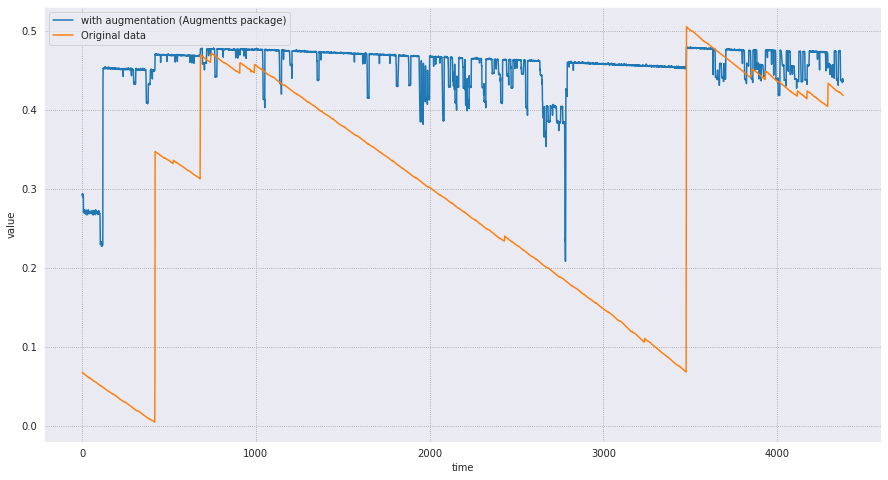

In [32]:
plt.figure(figsize=(15, 8))


plt.plot(
  gen_data[0][0],
  label='with augmentation (Augmentts package)'
)

plt.plot(
  serie[0],
  label='Original data'
)

plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

In [33]:
!pip install tsaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Experiment 2 : Binary disks classification (Without augmentation)**

#### **Models considered**


1.   K-Nearest neighbors 
2.   Logistic regression Classifier
3.   LSTM
4.   Bi-directional LSTM

#### **Evaluating Performance of the 4 models**



In [34]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 11.9 MB/s eta 0:00:00


In [35]:
import numpy as np
data = []
labels = []

test_data = []
test_labels = []
test_ids = []

test_normal = []
test_normal_labels = []

print(len(failed_disks))
it = 1

for id in failed_disks:

  if it < 3:
    test_data.append(hourly_data[id].values)
    test_labels.append(1)
    test_ids.append(id)
    it += 1
  
  else:
    data.append(hourly_data[id].values)
    labels.append(1)
    it += 1

  
print(len(data))
i=100

for col in hourly_data.columns:
  if col not in failed_disks and i > 30 :
    data.append(hourly_data[col].values)
    labels.append(0)
    i-=1
  
  elif i > 0:
    test_normal.append(hourly_data[col].values)
    test_normal_labels.append(0)
    i-=1



# Zip both arrays together
ab = list(zip(data, labels))

# Shuffle the zipped array
np.random.shuffle(ab)

# Unzip the shuffled array
data, labels = zip(*ab)

22
20


In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

X, y = data, labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [37]:
# Standardize the time series
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
# Train a logistic regression classifier
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42 ,max_iter=10000))
])
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Compute several metrics
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the performance report
print("Performance Report:\n")
print(f"Accuracy: {accuracy:.3f}")
print(f"ROC AUC: {roc_auc:.3f}\n")
print("Confusion Matrix:\n", confusion)
print("\nClassification Report:\n", classification)

Performance Report:

Accuracy: 0.861
ROC AUC: 0.688

Confusion Matrix:
 [[28  0]
 [ 5  3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92        28
           1       1.00      0.38      0.55         8

    accuracy                           0.86        36
   macro avg       0.92      0.69      0.73        36
weighted avg       0.88      0.86      0.84        36



In [39]:
y_pred_failed = clf.predict(scaler.transform(test_data))
y_pred_normal = clf.predict(scaler.transform(test_normal))
print(y_pred_failed)
print(y_pred_normal)

[0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [40]:
from tslearn.preprocessing import TimeSeriesScalerMinMax
X_scaled = TimeSeriesScalerMinMax().fit_transform(X_train)

In [41]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
knn = KNeighborsTimeSeriesClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print(knn.predict(X_test))

[0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [42]:
print(np.array(y_test))

[0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1]


In [43]:
print(knn.predict(scaler.transform(test_data)))

[0 1]


In [44]:
import tensorflow as tf

# Define RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(X_train[0]), 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

# Train model
model.fit(np.array(X_train), np.array(y_train), epochs=10, batch_size=32)

Epoch 1/10
2/2 [==============================] - 61s 28s/step - loss: 0.6948 - accuracy: 0.5185
Epoch 2/10
2/2 [==============================] - 57s 28s/step - loss: 0.6519 - accuracy: 0.8333
Epoch 3/10
2/2 [==============================] - 57s 28s/step - loss: 0.6124 - accuracy: 0.8148
Epoch 4/10
2/2 [==============================] - 58s 29s/step - loss: 0.5770 - accuracy: 0.8148
Epoch 5/10
2/2 [==============================] - 59s 29s/step - loss: 0.5415 - accuracy: 0.8148
Epoch 6/10
2/2 [==============================] - 57s 29s/step - loss: 0.5111 - accuracy: 0.8148
Epoch 7/10
2/2 [==============================] - 57s 28s/step - loss: 0.4833 - accuracy: 0.8148
Epoch 8/10
2/2 [==============================] - 57s 29s/step - loss: 0.4539 - accuracy: 0.8148
Epoch 9/10
2/2 [==============================] - 56s 28s/step - loss: 0.4211 - accuracy: 0.8148
Epoch 10/10
2/2 [==============================] - 57s 28s/step - loss: 0.3872 - accuracy: 0.8333


In [45]:
# Predict test data
y_pred = model.predict(np.array(X_test))

print(*zip(y_pred, y_test))

2/2 [==============================] - 24s 12s/step
(array([0.22852851], dtype=float32), 0) (array([0.8652877], dtype=float32), 1) (array([0.06758187], dtype=float32), 0) (array([0.04482134], dtype=float32), 1) (array([0.05539332], dtype=float32), 1) (array([0.05525113], dtype=float32), 0) (array([0.0598858], dtype=float32), 0) (array([0.0854362], dtype=float32), 0) (array([0.06488112], dtype=float32), 0) (array([0.05547699], dtype=float32), 0) (array([0.7528969], dtype=float32), 1) (array([0.6559655], dtype=float32), 0) (array([0.04645351], dtype=float32), 0) (array([0.25480205], dtype=float32), 0) (array([0.0598273], dtype=float32), 0) (array([0.04300614], dtype=float32), 0) (array([0.04674346], dtype=float32), 0) (array([0.08544116], dtype=float32), 0) (array([0.05525191], dtype=float32), 0) (array([0.5375179], dtype=float32), 1) (array([0.25480205], dtype=float32), 0) (array([0.25480205], dtype=float32), 0) (array([0.0261949], dtype=float32), 1) (array([0.10116654], dtype=float32),

In [46]:
test_data = scaler.transform(test_data)
y_pred = model.predict(np.array(test_data))

1/1 [==============================] - 11s 11s/step


In [47]:
y_pred

array([[0.5089589 ],
       [0.06175262]], dtype=float32)

In [48]:
import tensorflow as tf

# Define RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(X_train[0]), 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

# Train model
model.fit(np.array(X_train), np.array(y_train), epochs=10, batch_size=32)

Epoch 1/10
2/2 [==============================] - 121s 58s/step - loss: 0.6642 - accuracy: 0.6111
Epoch 2/10
2/2 [==============================] - 121s 61s/step - loss: 0.5709 - accuracy: 0.8148
Epoch 3/10
2/2 [==============================] - 119s 58s/step - loss: 0.4984 - accuracy: 0.8148
Epoch 4/10
2/2 [==============================] - 130s 71s/step - loss: 0.4417 - accuracy: 0.8148
Epoch 5/10
2/2 [==============================] - 131s 62s/step - loss: 0.4077 - accuracy: 0.8148
Epoch 6/10
2/2 [==============================] - 124s 58s/step - loss: 0.3925 - accuracy: 0.8148
Epoch 7/10
2/2 [==============================] - 121s 60s/step - loss: 0.3952 - accuracy: 0.8333
Epoch 8/10
2/2 [==============================] - 118s 58s/step - loss: 0.4005 - accuracy: 0.8148
Epoch 9/10
2/2 [==============================] - 146s 59s/step - loss: 0.3903 - accuracy: 0.8148
Epoch 10/10
2/2 [==============================] - 121s 61s/step - loss: 0.3774 - accuracy: 0.8148


In [49]:
# Predict test data
y_pred = model.predict(np.array(X_test))

print(*zip(y_pred, y_test))

2/2 [==============================] - 48s 22s/step
(array([0.09514264], dtype=float32), 0) (array([0.83387786], dtype=float32), 1) (array([0.02983477], dtype=float32), 0) (array([0.02098237], dtype=float32), 1) (array([0.02567119], dtype=float32), 1) (array([0.02532509], dtype=float32), 0) (array([0.02704264], dtype=float32), 0) (array([0.03614669], dtype=float32), 0) (array([0.02886211], dtype=float32), 0) (array([0.02540955], dtype=float32), 0) (array([0.7025783], dtype=float32), 1) (array([0.60409856], dtype=float32), 0) (array([0.0219591], dtype=float32), 0) (array([0.11024532], dtype=float32), 0) (array([0.02702115], dtype=float32), 0) (array([0.02059118], dtype=float32), 0) (array([0.02207275], dtype=float32), 0) (array([0.03614845], dtype=float32), 0) (array([0.02532538], dtype=float32), 0) (array([0.35789865], dtype=float32), 1) (array([0.11024532], dtype=float32), 0) (array([0.11024532], dtype=float32), 0) (array([0.01329669], dtype=float32), 1) (array([0.04165573], dtype=flo

In [50]:
test_data = scaler.transform(test_data)
y_pred = model.predict(np.array(test_data))

1/1 [==============================] - 23s 23s/step


In [51]:
y_pred

array([[0.81331927],
       [0.19073212]], dtype=float32)

### **Experiment 3 : Binary disks classification (With augmentation)**

#### **Baseline techniques for generating new failed instances**


1.   Adding constant 
2.   Multiplying constant

#### **Baseline and complex techniques for oversampling original failed instances**

1.   Baseline (convolution, cropping, ... etc)
2.   LSTMVAE

#### **Baseline techniques for generating new failed instances**

#### **Adding a constant value**


In [52]:
import numpy as np
data = []
labels = []

test_data = []
test_labels = []
test_ids = []

test_normal = []
test_normal_labels = []

print(len(failed_disks))
it = 1



for id in failed_disks:

  if it < 3:
    test_data.append(hourly_data[id].values)
    test_labels.append(1)
    test_ids.append(id)
    it += 1
  
  else:
    data.append(hourly_data[id].values)
    labels.append(1)
    it += 1

  

i=100

for col in hourly_data.columns:
  if col not in failed_disks and i > 50 :
    data.append(hourly_data[col].values)
    labels.append(0)
    i-=1

  elif col not in failed_disks and i > 70 :
    data.append(augm.add_const(hourly_data[col].values))
    labels.append(1)
    i-=1
  
  elif i > 0:
    test_normal.append(hourly_data[col].values)
    test_normal_labels.append(0)
    i-=1

print(len(data))


# Zip both arrays together
ab = list(zip(data, labels))

# Shuffle the zipped array
np.random.shuffle(ab)

# Unzip the shuffled array
data, labels = zip(*ab)

22
70


In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

X, y = data, labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [54]:
# Standardize the time series
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [55]:
# Train a logistic regression classifier
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42 ,max_iter=10000))
])
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Compute several metrics
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the performance report
print("Performance Report:\n")
print(f"Accuracy: {accuracy:.3f}")
print(f"ROC AUC: {roc_auc:.3f}\n")
print("Confusion Matrix:\n", confusion)
print("\nClassification Report:\n", classification)

Performance Report:

Accuracy: 0.786
ROC AUC: 0.700

Confusion Matrix:
 [[18  0]
 [ 6  4]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86        18
           1       1.00      0.40      0.57        10

    accuracy                           0.79        28
   macro avg       0.88      0.70      0.71        28
weighted avg       0.84      0.79      0.76        28



In [56]:
y_pred_failed = clf.predict(scaler.transform(test_data))
y_pred_normal = clf.predict(scaler.transform(test_normal))
print(y_pred_failed)
print(y_pred_normal)

[0 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [57]:
import tensorflow as tf

# Define RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(X_train[0]), 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

# Train model
model.fit(np.array(X_train), np.array(y_train), epochs=10, batch_size=32)

Epoch 1/10
2/2 [==============================] - 56s 27s/step - loss: 0.6825 - accuracy: 0.7381
Epoch 2/10
2/2 [==============================] - 56s 28s/step - loss: 0.6412 - accuracy: 0.8095
Epoch 3/10
2/2 [==============================] - 55s 27s/step - loss: 0.6079 - accuracy: 0.8333
Epoch 4/10
2/2 [==============================] - 56s 27s/step - loss: 0.5759 - accuracy: 0.8333
Epoch 5/10
2/2 [==============================] - 56s 27s/step - loss: 0.5448 - accuracy: 0.8333
Epoch 6/10
2/2 [==============================] - 57s 28s/step - loss: 0.5250 - accuracy: 0.8333
Epoch 7/10
2/2 [==============================] - 57s 28s/step - loss: 0.5003 - accuracy: 0.8333
Epoch 8/10
2/2 [==============================] - 56s 27s/step - loss: 0.4732 - accuracy: 0.8333
Epoch 9/10
2/2 [==============================] - 56s 27s/step - loss: 0.4560 - accuracy: 0.8333
Epoch 10/10
2/2 [==============================] - 56s 28s/step - loss: 0.4380 - accuracy: 0.8571


In [58]:
# Predict test data
y_pred = model.predict(np.array(X_test))

print(*zip(y_pred, y_test))

1/1 [==============================] - 12s 12s/step
(array([0.06027897], dtype=float32), 0) (array([0.11790715], dtype=float32), 0) (array([0.22683376], dtype=float32), 0) (array([0.86276096], dtype=float32), 1) (array([0.04770093], dtype=float32), 0) (array([0.88185626], dtype=float32), 1) (array([0.06028005], dtype=float32), 0) (array([0.06028005], dtype=float32), 0) (array([0.080942], dtype=float32), 0) (array([0.06009263], dtype=float32), 0) (array([0.56169564], dtype=float32), 0) (array([0.88050634], dtype=float32), 1) (array([0.05090428], dtype=float32), 0) (array([0.06112329], dtype=float32), 0) (array([0.06891027], dtype=float32), 0) (array([0.22683376], dtype=float32), 0) (array([0.08094531], dtype=float32), 0) (array([0.847333], dtype=float32), 1) (array([0.25682005], dtype=float32), 1) (array([0.7986868], dtype=float32), 1) (array([0.7344762], dtype=float32), 0) (array([0.09130643], dtype=float32), 0) (array([0.05069685], dtype=float32), 0) (array([0.8923393], dtype=float32)

In [59]:
test_data = scaler.transform(test_data)
y_pred = model.predict(np.array(test_data))

1/1 [==============================] - 11s 11s/step


In [60]:
y_pred

array([[0.41085428],
       [0.0648146 ]], dtype=float32)

In [61]:
import tensorflow as tf

# Define RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(X_train[0]), 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

# Train model
model.fit(np.array(X_train), np.array(y_train), epochs=10, batch_size=32)

Epoch 1/10
2/2 [==============================] - 117s 57s/step - loss: 0.6972 - accuracy: 0.3810
Epoch 2/10
2/2 [==============================] - 116s 56s/step - loss: 0.6257 - accuracy: 0.8571
Epoch 3/10
2/2 [==============================] - 118s 57s/step - loss: 0.5861 - accuracy: 0.8571
Epoch 4/10
2/2 [==============================] - 119s 58s/step - loss: 0.5461 - accuracy: 0.8571
Epoch 5/10
2/2 [==============================] - 118s 57s/step - loss: 0.5136 - accuracy: 0.8571
Epoch 6/10
2/2 [==============================] - 117s 56s/step - loss: 0.4753 - accuracy: 0.8333
Epoch 7/10
2/2 [==============================] - 115s 55s/step - loss: 0.4483 - accuracy: 0.8571
Epoch 8/10
2/2 [==============================] - 115s 56s/step - loss: 0.4367 - accuracy: 0.8571
Epoch 9/10
2/2 [==============================] - 115s 56s/step - loss: 0.4228 - accuracy: 0.8333
Epoch 10/10
2/2 [==============================] - 115s 56s/step - loss: 0.4203 - accuracy: 0.8095


In [62]:
# Predict test data
y_pred = model.predict(np.array(X_test))

print(*zip(y_pred, y_test))

1/1 [==============================] - 25s 25s/step
(array([0.05151888], dtype=float32), 0) (array([0.07212853], dtype=float32), 0) (array([0.11245368], dtype=float32), 0) (array([0.8200823], dtype=float32), 1) (array([0.04649651], dtype=float32), 0) (array([0.8323977], dtype=float32), 1) (array([0.0515193], dtype=float32), 0) (array([0.0515193], dtype=float32), 0) (array([0.05924062], dtype=float32), 0) (array([0.05144677], dtype=float32), 0) (array([0.5080042], dtype=float32), 0) (array([0.8297933], dtype=float32), 1) (array([0.04781064], dtype=float32), 0) (array([0.05184501], dtype=float32), 0) (array([0.0548052], dtype=float32), 0) (array([0.11245368], dtype=float32), 0) (array([0.05924181], dtype=float32), 0) (array([0.80008465], dtype=float32), 1) (array([0.13528539], dtype=float32), 1) (array([0.7674177], dtype=float32), 1) (array([0.7186832], dtype=float32), 0) (array([0.0629525], dtype=float32), 0) (array([0.04772643], dtype=float32), 0) (array([0.83847475], dtype=float32), 1

In [63]:
test_data = scaler.transform(test_data)
y_pred = model.predict(np.array(test_data))

1/1 [==============================] - 22s 22s/step


In [64]:
y_pred

array([[0.84143245],
       [0.5065652 ]], dtype=float32)

#### **Multiplying by constant value**

In [65]:
import numpy as np
data = []
labels = []

test_data = []
test_labels = []
test_ids = []

test_normal = []
test_normal_labels = []

print(len(failed_disks))
it = 1



for id in failed_disks:

  if it < 3:
    test_data.append(hourly_data[id].values)
    test_labels.append(1)
    test_ids.append(id)
    it += 1
  
  else:
    data.append(hourly_data[id].values)
    labels.append(1)
    it += 1

  

i=100

for col in hourly_data.columns:
  if col not in failed_disks and i > 50 :
    data.append(hourly_data[col].values)
    labels.append(0)
    i-=1

  elif col not in failed_disks and i > 70 :
    data.append(augm.mult_const(hourly_data[col].values))
    labels.append(1)
    i-=1
  
  elif i > 0:
    test_normal.append(hourly_data[col].values)
    test_normal_labels.append(0)
    i-=1

print(len(data))


# Zip both arrays together
ab = list(zip(data, labels))

# Shuffle the zipped array
np.random.shuffle(ab)

# Unzip the shuffled array
data, labels = zip(*ab)

22
70


In [66]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

X, y = data, labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [67]:
# Standardize the time series
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
# Train a logistic regression classifier
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42 ,max_iter=10000))
])
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Compute several metrics
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the performance report
print("Performance Report:\n")
print(f"Accuracy: {accuracy:.3f}")
print(f"ROC AUC: {roc_auc:.3f}\n")
print("Confusion Matrix:\n", confusion)
print("\nClassification Report:\n", classification)

Performance Report:

Accuracy: 0.857
ROC AUC: 0.600

Confusion Matrix:
 [[23  0]
 [ 4  1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92        23
           1       1.00      0.20      0.33         5

    accuracy                           0.86        28
   macro avg       0.93      0.60      0.63        28
weighted avg       0.88      0.86      0.82        28



In [69]:
y_pred_failed = clf.predict(scaler.transform(test_data))
y_pred_normal = clf.predict(scaler.transform(test_normal))
print(y_pred_failed)
print(y_pred_normal)

[0 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [70]:
import tensorflow as tf

# Define RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(X_train[0]), 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

# Train model
model.fit(np.array(X_train), np.array(y_train), epochs=10, batch_size=32)

Epoch 1/10
2/2 [==============================] - 56s 28s/step - loss: 0.6883 - accuracy: 0.5238
Epoch 2/10
2/2 [==============================] - 56s 28s/step - loss: 0.6307 - accuracy: 0.8571
Epoch 3/10
2/2 [==============================] - 56s 27s/step - loss: 0.5802 - accuracy: 0.8571
Epoch 4/10
2/2 [==============================] - 55s 27s/step - loss: 0.5399 - accuracy: 0.8571
Epoch 5/10
2/2 [==============================] - 55s 28s/step - loss: 0.5029 - accuracy: 0.8571
Epoch 6/10
2/2 [==============================] - 56s 27s/step - loss: 0.4682 - accuracy: 0.8571
Epoch 7/10
2/2 [==============================] - 56s 28s/step - loss: 0.4460 - accuracy: 0.8571
Epoch 8/10
2/2 [==============================] - 56s 28s/step - loss: 0.4322 - accuracy: 0.8571
Epoch 9/10
2/2 [==============================] - 56s 27s/step - loss: 0.4183 - accuracy: 0.8571
Epoch 10/10
2/2 [==============================] - 55s 27s/step - loss: 0.4143 - accuracy: 0.8571


In [71]:
# Predict test data
y_pred = model.predict(np.array(X_test))

print(*zip(y_pred, y_test))

1/1 [==============================] - 12s 12s/step
(array([0.2986272], dtype=float32), 0) (array([0.10041463], dtype=float32), 0) (array([0.8814254], dtype=float32), 1) (array([0.21256429], dtype=float32), 0) (array([0.11347764], dtype=float32), 0) (array([0.10216065], dtype=float32), 0) (array([0.12219071], dtype=float32), 0) (array([0.11248221], dtype=float32), 0) (array([0.1862468], dtype=float32), 0) (array([0.11228556], dtype=float32), 0) (array([0.96520287], dtype=float32), 1) (array([0.9743678], dtype=float32), 0) (array([0.11248221], dtype=float32), 0) (array([0.6716768], dtype=float32), 1) (array([0.11252253], dtype=float32), 1) (array([0.23417278], dtype=float32), 0) (array([0.25469446], dtype=float32), 0) (array([0.2985532], dtype=float32), 0) (array([0.10213304], dtype=float32), 1) (array([0.11228956], dtype=float32), 0) (array([0.11619005], dtype=float32), 0) (array([0.11248088], dtype=float32), 0) (array([0.10069113], dtype=float32), 0) (array([0.11228556], dtype=float32

In [72]:
test_data = scaler.transform(test_data)
y_pred = model.predict(np.array(test_data))

1/1 [==============================] - 12s 12s/step


In [73]:
y_pred

array([[0.6203552 ],
       [0.11772051]], dtype=float32)

In [74]:
import tensorflow as tf

# Define RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(X_train[0]), 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

# Train model
model.fit(np.array(X_train), np.array(y_train), epochs=10, batch_size=32)

Epoch 1/10
2/2 [==============================] - 116s 56s/step - loss: 0.6466 - accuracy: 0.8095
Epoch 2/10
2/2 [==============================] - 116s 57s/step - loss: 0.5715 - accuracy: 0.8333
Epoch 3/10
2/2 [==============================] - 116s 57s/step - loss: 0.5092 - accuracy: 0.8333
Epoch 4/10
2/2 [==============================] - 114s 55s/step - loss: 0.4566 - accuracy: 0.8571
Epoch 5/10
2/2 [==============================] - 114s 55s/step - loss: 0.4298 - accuracy: 0.8571
Epoch 6/10
2/2 [==============================] - 115s 56s/step - loss: 0.4177 - accuracy: 0.8333
Epoch 7/10
2/2 [==============================] - 115s 56s/step - loss: 0.4160 - accuracy: 0.8333
Epoch 8/10
2/2 [==============================] - 117s 57s/step - loss: 0.4176 - accuracy: 0.8333
Epoch 9/10
2/2 [==============================] - 116s 56s/step - loss: 0.4204 - accuracy: 0.8333
Epoch 10/10
2/2 [==============================] - 115s 55s/step - loss: 0.4151 - accuracy: 0.8571


In [75]:
# Predict test data
y_pred = model.predict(np.array(X_test))

print(*zip(y_pred, y_test))

1/1 [==============================] - 24s 24s/step
(array([0.2613167], dtype=float32), 0) (array([0.09517711], dtype=float32), 0) (array([0.8681056], dtype=float32), 1) (array([0.17674166], dtype=float32), 0) (array([0.10337348], dtype=float32), 0) (array([0.09626217], dtype=float32), 0) (array([0.10897148], dtype=float32), 0) (array([0.10274144], dtype=float32), 0) (array([0.16949512], dtype=float32), 0) (array([0.10261671], dtype=float32), 0) (array([0.95139265], dtype=float32), 1) (array([0.9601627], dtype=float32), 0) (array([0.10274144], dtype=float32), 0) (array([0.6716359], dtype=float32), 1) (array([0.10295689], dtype=float32), 1) (array([0.21518895], dtype=float32), 0) (array([0.2156241], dtype=float32), 0) (array([0.26123556], dtype=float32), 0) (array([0.09622987], dtype=float32), 1) (array([0.10261925], dtype=float32), 0) (array([0.10510322], dtype=float32), 0) (array([0.10274056], dtype=float32), 0) (array([0.09534876], dtype=float32), 0) (array([0.10261671], dtype=float3

In [76]:
y_pred

array([[0.2613167 ],
       [0.09517711],
       [0.8681056 ],
       [0.17674166],
       [0.10337348],
       [0.09626217],
       [0.10897148],
       [0.10274144],
       [0.16949512],
       [0.10261671],
       [0.95139265],
       [0.9601627 ],
       [0.10274144],
       [0.6716359 ],
       [0.10295689],
       [0.21518895],
       [0.2156241 ],
       [0.26123556],
       [0.09622987],
       [0.10261925],
       [0.10510322],
       [0.10274056],
       [0.09534876],
       [0.10261671],
       [0.10260022],
       [0.0926539 ],
       [0.1385999 ],
       [0.09438025]], dtype=float32)

#### **Using LSTMVAE for augmentation (failed disks oversampling)**

In [77]:
from augmentts.augmenters.vae import LSTMVAE, VAEAugmenter

# create a variational autoencoder
vae = LSTMVAE(series_len=4380)
# create an augmenter
augmenter = VAEAugmenter(vae)

In [78]:
augm_series = []

for i in range(22):
  data = []
  nb_set = 0
  for id in failed_disks:
    serie = []
    serie.append(hourly_data[id].values.tolist())
    data.append(serie)
    nb_set+=1

    if nb_set == i:
      break;

  data = np.array(data)
  print(data.shape)
  augmenter.fit(data, epochs=100, batch_size=32)
  gen_data = augmenter.sample(n=1, sigma=1)
  gen_data = gen_data.numpy()

  augm_series.append(gen_data)

(22, 1, 4380)
Epoch 1/100
1/1 [==============================] - 0s 449ms/step - loss: 5.9885 - reconstruction_loss: 5.9885 - kl_loss: 2.1468e-08
Epoch 2/100
1/1 [==============================] - 0s 360ms/step - loss: 5.9698 - reconstruction_loss: 5.9698 - kl_loss: 2.0789e-08
Epoch 3/100
1/1 [==============================] - 0s 352ms/step - loss: 5.9511 - reconstruction_loss: 5.9511 - kl_loss: 3.7472e-08
Epoch 4/100
1/1 [==============================] - 0s 368ms/step - loss: 5.9316 - reconstruction_loss: 5.9316 - kl_loss: 1.8235e-07
Epoch 5/100
1/1 [==============================] - 0s 337ms/step - loss: 5.9099 - reconstruction_loss: 5.9099 - kl_loss: 5.0466e-07
Epoch 6/100
1/1 [==============================] - 0s 374ms/step - loss: 5.8876 - reconstruction_loss: 5.8876 - kl_loss: 1.0722e-06
Epoch 7/100
1/1 [==============================] - 0s 414ms/step - loss: 5.8631 - reconstruction_loss: 5.8630 - kl_loss: 2.0132e-06
Epoch 8/100
1/1 [==============================] - 0s 413ms/st

In [79]:
augm_series_values = []

for i  in range(len(augm_series)): 
  augm_series_values.append(augm_series[i][0][0])

import numpy as np
data = []
labels = []

test_data = []
test_labels = []
test_ids = []

test_normal = []
test_normal_labels = []

print(len(failed_disks))
it = 1



for id in failed_disks:

  if it < 3:
    test_data.append(hourly_data[id].values)
    test_labels.append(1)
    test_ids.append(id)
    it += 1
  
  else:
    data.append(hourly_data[id].values)
    labels.append(1)
    it += 1

  
for i in range(len(augm_series_values)):
  data.append(augm_series_values[i])
  labels.append(1)
  i-=1
 

i=80

for col in hourly_data.columns:
  if col not in failed_disks and i > 50 :
    data.append(hourly_data[col].values)
    labels.append(0)
    i-=1
  
  elif i > 0:
    test_normal.append(hourly_data[col].values)
    test_normal_labels.append(0)
    i-=1

print(len(data))


# Zip both arrays together
ab = list(zip(data, labels))

# Shuffle the zipped array
np.random.shuffle(ab)

# Unzip the shuffled array
data, labels = zip(*ab)

22
72


In [80]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

X, y = data, labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [81]:
# Standardize the time series
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [82]:
# Train a logistic regression classifier
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42 ,max_iter=10000))
])
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Compute several metrics
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the performance report
print("Performance Report:\n")
print(f"Accuracy: {accuracy:.3f}")
print(f"ROC AUC: {roc_auc:.3f}\n")
print("Confusion Matrix:\n", confusion)
print("\nClassification Report:\n", classification)

Performance Report:

Accuracy: 0.862
ROC AUC: 0.875

Confusion Matrix:
 [[13  0]
 [ 4 12]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      1.00      0.87        13
           1       1.00      0.75      0.86        16

    accuracy                           0.86        29
   macro avg       0.88      0.88      0.86        29
weighted avg       0.89      0.86      0.86        29



In [83]:
y_pred_failed = clf.predict(scaler.transform(test_data))
y_pred_normal = clf.predict(scaler.transform(test_normal))
print(y_pred_failed)
print(y_pred_normal)

[1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [84]:
import tensorflow as tf

# Define RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(X_train[0]), 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

# Train model
model.fit(np.array(X_train), np.array(y_train), epochs=10, batch_size=32)

Epoch 1/10
2/2 [==============================] - 56s 28s/step - loss: 0.7167 - accuracy: 0.2093
Epoch 2/10
2/2 [==============================] - 54s 26s/step - loss: 0.6666 - accuracy: 0.8140
Epoch 3/10
2/2 [==============================] - 56s 27s/step - loss: 0.6202 - accuracy: 0.8140
Epoch 4/10
2/2 [==============================] - 55s 27s/step - loss: 0.5813 - accuracy: 0.8140
Epoch 5/10
2/2 [==============================] - 56s 27s/step - loss: 0.5429 - accuracy: 0.8372
Epoch 6/10
2/2 [==============================] - 54s 26s/step - loss: 0.5125 - accuracy: 0.8372
Epoch 7/10
2/2 [==============================] - 56s 28s/step - loss: 0.4798 - accuracy: 0.8372
Epoch 8/10
2/2 [==============================] - 55s 27s/step - loss: 0.4653 - accuracy: 0.8372
Epoch 9/10
2/2 [==============================] - 55s 27s/step - loss: 0.4451 - accuracy: 0.8372
Epoch 10/10
2/2 [==============================] - 54s 26s/step - loss: 0.4414 - accuracy: 0.8605


In [85]:
# Predict test data
y_pred = model.predict(np.array(X_test))

print(*zip(y_pred, y_test))

1/1 [==============================] - 12s 12s/step
(array([0.9759468], dtype=float32), 1) (array([0.95124805], dtype=float32), 1) (array([0.9313962], dtype=float32), 1) (array([0.20584634], dtype=float32), 1) (array([0.20512308], dtype=float32), 0) (array([0.55022246], dtype=float32), 0) (array([0.96713537], dtype=float32), 1) (array([0.3063488], dtype=float32), 0) (array([0.20512308], dtype=float32), 0) (array([0.962345], dtype=float32), 1) (array([0.21183988], dtype=float32), 0) (array([0.23742247], dtype=float32), 0) (array([0.9613739], dtype=float32), 1) (array([0.21981479], dtype=float32), 0) (array([0.2058235], dtype=float32), 0) (array([0.9624784], dtype=float32), 1) (array([0.28586724], dtype=float32), 0) (array([0.20771836], dtype=float32), 0) (array([0.9694891], dtype=float32), 1) (array([0.26060802], dtype=float32), 1) (array([0.9618222], dtype=float32), 1) (array([0.95376563], dtype=float32), 1) (array([0.52841586], dtype=float32), 1) (array([0.95812184], dtype=float32), 1

In [86]:
test_data = scaler.transform(test_data)
y_pred = model.predict(np.array(test_data))

1/1 [==============================] - 11s 11s/step


In [87]:
y_pred

array([[0.82699233],
       [0.20877406]], dtype=float32)